Variational Auto Encoder
Used https://github.com/ogreen8084/deep_learning_stuff/blob/master/variational_autoencoder_tensorflow_rev_layers.ipynb
For my next revision, I will clean it up with functions

In [1]:
#Dependencies:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'1.0.1'

In [3]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
#Functions
def sampleGaussian(mu, log_sigma):
    """(Differentiably!) draw sample from Gaussian with given shape, subject to random noise epsilon"""
    epsilon = tf.random_normal(tf.shape(log_sigma), name="epsilon")
    return mu + epsilon * tf.exp(log_sigma) # N(mu, I * sigma**2)

def crossEntropy(obs, actual, offset=1e-7):
    """Binary cross-entropy, per training example"""
    # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
        # bound by clipping to avoid nan
    obs_ = tf.clip_by_value(obs, offset, 1 - offset)
    return -tf.reduce_sum(actual * tf.log(obs_) +
                          (1 - actual) * tf.log(1 - obs_), 1)
def kullbackLeibler(mu, log_sigma):
    # = -0.5 * (1 + log(sigma**2) - mu**2 - sigma**2)
    return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 -
                                tf.exp(2 * log_sigma), 1)

def plotSubset(x_in, x_reconstructed, n=10, cols=None, outlines=True,
               save=True, name="subset", outdir="."):
    """Util to plot subset of inputs and reconstructed outputs"""
    n = min(n, x_in.shape[0])
    cols = (cols if cols else n)
    rows = 2 * int(np.ceil(n / cols)) # doubled b/c input & reconstruction

    plt.figure(figsize = (cols * 2, rows * 2))
    dim = 28 # assume square images

    def drawSubplot(x_, ax_):
        plt.imshow(x_.reshape([dim, dim]), cmap="Greys")
        if outlines:
            ax_.get_xaxis().set_visible(False)
            ax_.get_yaxis().set_visible(False)
        else:
            ax_.set_axis_off()

    for i, x in enumerate(x_in[:n], 1):
        # display original
        ax = plt.subplot(rows, cols, i) # rows, cols, subplot numbered from 1
        drawSubplot(x, ax)

    for i, x in enumerate(x_reconstructed[:n], 1):
        # display reconstruction
        ax = plt.subplot(rows, cols, i + cols * (rows / 2))
        drawSubplot(x, ax)

    plt.show()

In [5]:
#Architecture variables
input_dim = 784
encode_architecture = [600, 400, 200, 100]
decode_architecture = [200, 400, 600, input_dim]
nonlinearity = tf.nn.relu
squashing = tf.nn.sigmoid
learning_rate = 1e-5
batch_size = 128
plots_outdir="./png"
lambda_l2_reg = 0.1
n_hidden1 = 600
n_hidden2 = 300
n_hidden3 = 20

In [6]:
#encoder weights
enc_w1 = tf.get_variable("enc_1", shape=[input_dim, n_hidden1], initializer=tf.contrib.layers.xavier_initializer())
enc_b1 = tf.Variable(tf.zeros(n_hidden1), dtype=tf.float32)
enc_w2 = tf.get_variable("enc_2", shape=[n_hidden1, n_hidden2], initializer=tf.contrib.layers.xavier_initializer())
enc_b2 = tf.Variable(tf.zeros(n_hidden2), dtype=tf.float32)
enc_w3 = tf.get_variable("enc_3", shape=[n_hidden2, n_hidden3], initializer=tf.contrib.layers.xavier_initializer())
enc_b3 = tf.Variable(tf.zeros(n_hidden3), dtype=tf.float32)

In [7]:
log_sigma_w1 = tf.get_variable('log_sigma_w1', shape=[n_hidden2, n_hidden3], initializer=tf.contrib.layers.xavier_initializer())
log_sigma_b1 = tf.Variable(tf.zeros(n_hidden3), dtype=tf.float32)

In [8]:
#decoder weights
dec_w1 = tf.get_variable("dec_1", shape=[n_hidden3, n_hidden2], initializer=tf.contrib.layers.xavier_initializer())
dec_b1 = tf.Variable(tf.zeros([n_hidden2], dtype=tf.float32))
dec_w2 = tf.get_variable("dec_2", shape=[n_hidden2, n_hidden1], initializer=tf.contrib.layers.xavier_initializer())
dec_b2 = tf.Variable(tf.zeros([n_hidden1], dtype=tf.float32))
dec_w3 = tf.get_variable("dec_3", shape=[n_hidden1, input_dim], initializer=tf.contrib.layers.xavier_initializer())
dec_b3 = tf.Variable(tf.zeros([input_dim], dtype=tf.float32))

In [9]:
x_in = tf.placeholder(tf.float32, (None, input_dim))

enc_layer_1 = tf.nn.elu(tf.add(tf.matmul(x_in, enc_w1), enc_b1))
enc_layer_2 = tf.nn.elu(tf.add(tf.matmul(enc_layer_1, enc_w2), enc_b2))


In [10]:
z_mean = tf.nn.elu(tf.add(tf.matmul(enc_layer_2, enc_w3), enc_b3))
z_log_sigma_sq = tf.nn.elu(tf.add(tf.matmul(enc_layer_2, log_sigma_w1), log_sigma_b1))
eps = tf.random_normal(tf.stack([tf.shape(enc_layer_2)[0], n_hidden3]), 0, 1, dtype=tf.float32)

In [11]:
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))

In [12]:
dec_layer_1 = tf.nn.elu(tf.add(tf.matmul(z, dec_w1), dec_b1))
dec_layer_2 = tf.nn.elu(tf.add(tf.matmul(dec_layer_1, dec_w2), dec_b2))

reconstruction = tf.nn.sigmoid(tf.add(tf.matmul(dec_layer_2, dec_w3), dec_b3))
reconstr_loss = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(reconstruction, x_in), 2.0))
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq 
                                  -tf.square(z_mean)
                                  -tf.exp(z_log_sigma_sq), 1)


In [13]:
cost = tf.reduce_mean(reconstr_loss + latent_loss)
optimizer = tf.train.AdamOptimizer().minimize(cost)


In [14]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Iteration: 0 cost: 11815.776367
Samples:


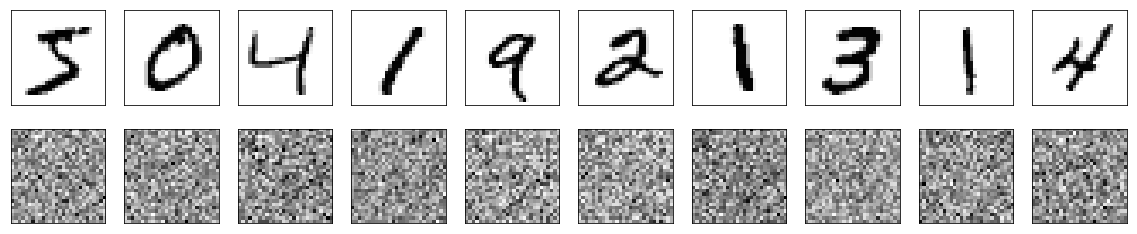

Iteration: 100 cost: 1831.427979
Samples:


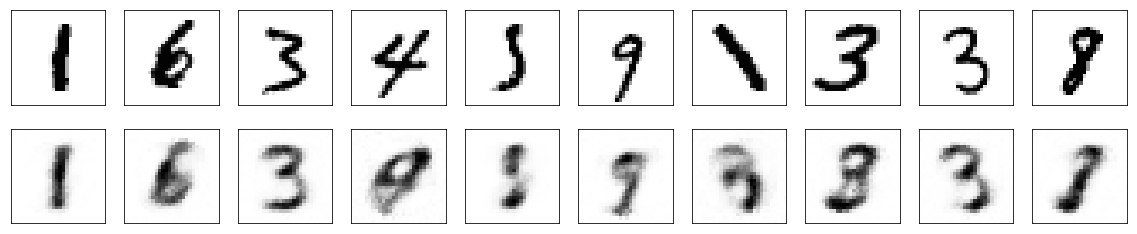

Iteration: 200 cost: 1467.315430
Samples:


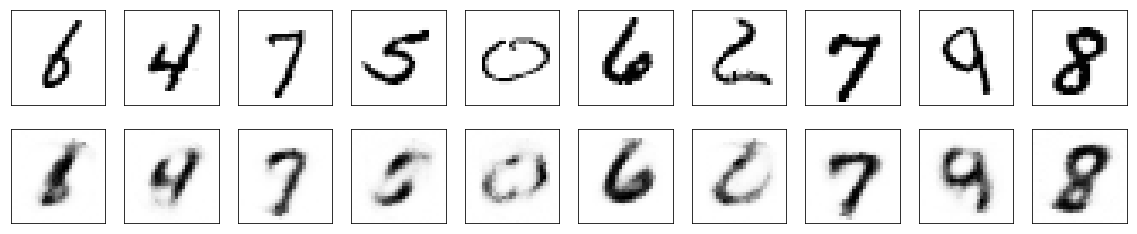

Iteration: 300 cost: 1338.679199
Samples:


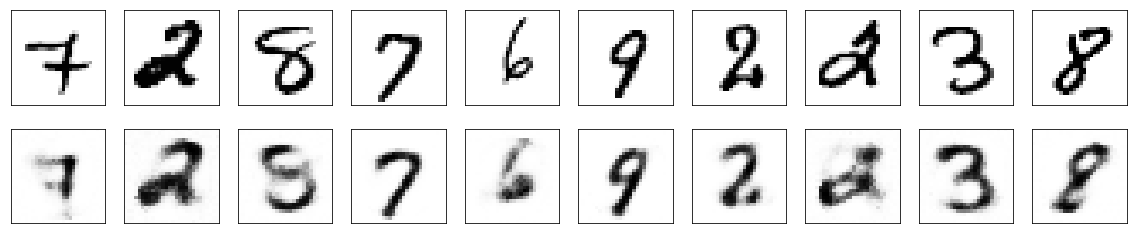

Iteration: 400 cost: 1265.403809
Samples:


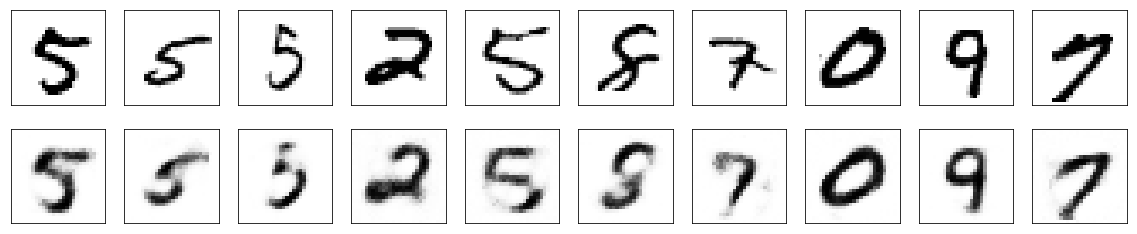

Iteration: 500 cost: 1162.590088
Samples:


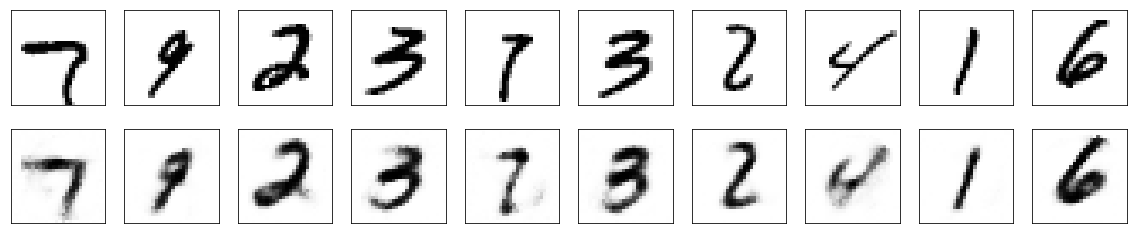

Iteration: 600 cost: 1041.981934
Samples:


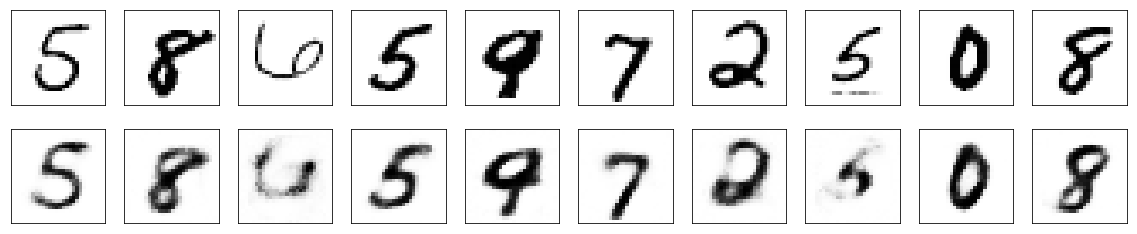

Iteration: 700 cost: 1019.337769
Samples:


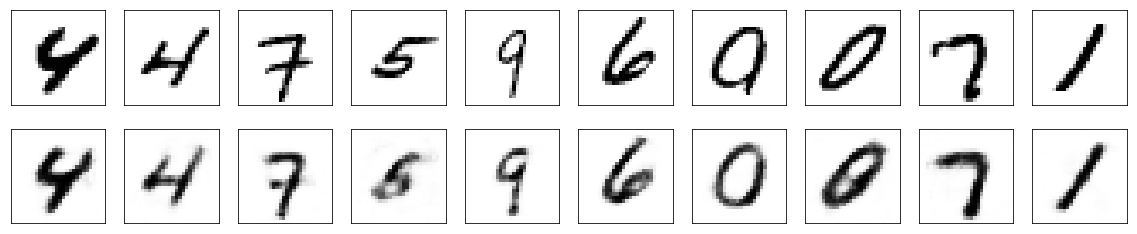

Iteration: 800 cost: 1017.614868
Samples:


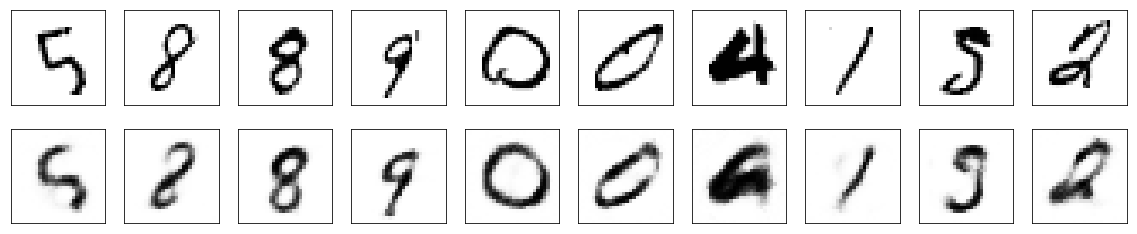

Iteration: 900 cost: 1011.028809
Samples:


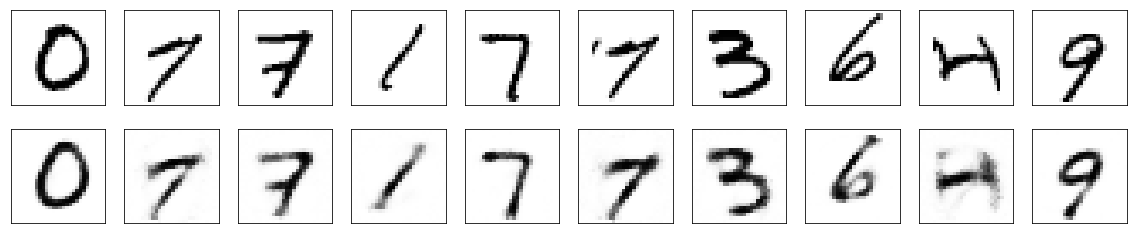

Iteration: 1000 cost: 946.016479
Samples:


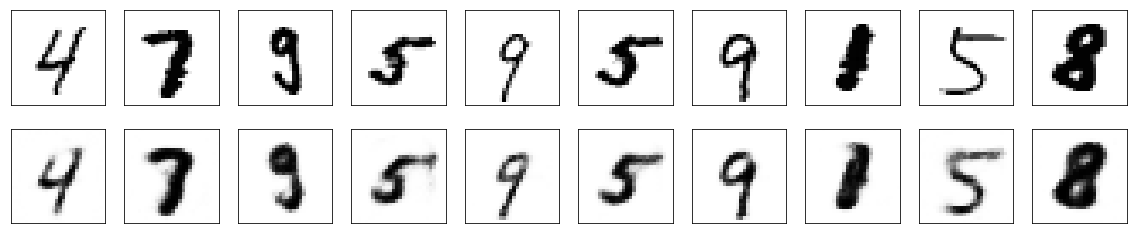

KeyboardInterrupt: 

In [15]:
for i in range(5000):
    x, _= mnist.train.next_batch(batch_size)

    _, c = sess.run([optimizer, cost], feed_dict={x_in: x/1.})
    if i % 100 == 0:
        print("Iteration: %d cost: %f" %(i, c))

        print("Samples:")

        x2, _ = mnist.validation.next_batch(batch_size)
        feed_dict2 = {x_in: x2}
        fetches2 = [reconstruction, cost]
        x_prime2, cost2 = sess.run(fetches2, feed_dict2)
        plotSubset(x2, x_prime2, n=10, name="cv",
                        outdir=plots_outdir)
